In [1]:
# import logging
import os
import re 
from pathlib import Path
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import torch
import wandb
import yaml
from einops import rearrange

In [ ]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from mushroom.mushroom import Mushroom
import mushroom.data.xenium as xenium
import mushroom.data.visium as visium
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils

/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()


In [5]:
wandb.login()

wandb: Currently logged in as: estorrs (tme-st). Use `wandb login --relogin` to force relogin


True

In [6]:
run_dir = '/data/estorrs/mushroom/data/projects/htan_talk'
mushroom_dir = os.path.join(run_dir, 'mushroom')
config_fps = sorted(utils.listfiles(mushroom_dir, regex=r'/config.yaml'))
config_fps = [fp for fp in config_fps if 'wandb' not in fp]
config_fps

['/data/estorrs/mushroom/data/projects/htan_talk/mushroom/HT225C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/htan_talk/mushroom/S18-9906/config.yaml']

In [7]:
# only relavent for dinglab data since our channel names are all over the place
# will remove for official example
official_to_options = {
    'Pan-Cytokeratin': ['Pan-Cytokeratin', 'Pan-CK', 'Pan-CK (D)', 'PanCK (D)'],
    'E-cadherin': ['E-cadherin'],
    'CD45': ['CD45 (D)', 'CD45', 'CD45-(D)', 'CD45(D)'],
    'CD45RO': ['CD45RO'],
    'CD45RA': ['CD45RA'],
    'CD8': ['CD8', 'CD8a'],
    'DAPI': ['DAPI'],
    'CD4': ['CD4', 'CD4 (D)'],
    'CD3e': ['CD3e', 'CD3'],
    'Vimentin': ['Vimentin-(D)', 'Vimentin', 'Vimentin (D)'],
    'SMA': ['SMA-(D)', 'SMA', 'SMA (D)', 'a-SMA (D)'],
    'CD31': ['CD31', 'CD31-(D)', 'CD31 (D)'],
    'CD20': ['CD20-(D)', 'CD20', 'CD20 (D)', 'CD20-Akoya'],
    'CD68': ['CD68', 'CD68 (D)', 'CD68-(D)'],
    'CD163': ['CD163'],
    'FOXP3': ['FoxP3', 'FOXP3', 'Foxp3'],
    'cKit': ['cKIT (D)', 'cKit (D)', 'cKit', 'cKIT', 'cKIT-(D)'],
    'MGP': ['MGP', 'MGP (D)', 'MGP-(D)'],
    'CD36': ['CD36-(D)', 'CD36'],
    'PR': ['PR', 'PR-(D)', 'PR (D)'],
    'ER': ['ER', 'ER-(D)', 'ER (D)'],
    'P21': ['P21', 'P21-(D)', 'P21-(D)', 'P21 (D)'],
    'P16': ['P16-(D)'],
    'CK5': ['Keratin 5', 'KRT5'],
    'TFF1': ['TFF1', 'TFF1-(D)', 'TFF1 (D)'],
    'beta-integrin': ['beta-integrin', 'beta3-integrin'],
    'CK14': ['CK14', 'Keratin 14', 'CK14 (D)'],
    'CK17': ['CK17', 'CK17 (D)', 'CK17-(D)', 'Keratin 17'],
    'CK19': ['CK19', 'CK19 (D)', 'CK19-(D)'],
    'CD11b': ['CD11b', 'CD11b (D)', 'CD11b-(D)'],
    'GATA3': ['GATA3', 'GATA3-(D)', 'GATA3 (D)'],
    'PLAT/tPA': ['PLAT/tPA', 'PLAT/tPA (D)'],
    'COX6c': ['COX6c (D)'],
    'Her2': ['Her2', 'Her2 (D)'],
    'Bap1': ['Bap1 (D)'],
    'GLUT1': ['Glut1', 'GLUT1', 'GLUT1-(D)', 'GLUT1 (D)'],
    'CD11c': ['CD11c'],
    'HLA-DR': ['HLA-DR'],
    'Ki67': ['Ki67', 'KI67'],
    'Podoplanin': ['Podoplanin', 'PDPN', 'Podoplanin (D)'],
    'CTLA4': ['CTLA4', 'CTLA4 (D)', 'CTLA4-(D)'],
    'SLC39A6': ['SLC39A6'],
    'BCA1': ['BCA1'],
    'BCAL': ['BCAL'],
    'TUBB3': ['TUBB3', 'TUBB3 (D)'],
    'PTPRZ1': ['PTPRZ1', 'PTPRZ1 (D)'],
    'HIF1A': ['HIF1a', 'HIF1a (D)', 'HIF1A'],
    'PAI1': ['PAI1', 'PAI1-(D)'],
    'GFAP': ['GFAP', 'GFAP (D)'],
    'VEGFA': ['VEGFA', 'VEGFA (D)'],
    'IBA1': ['IBA1', 'IBA1 (D)'],
    'OLIG2': ['OLIG2', 'OLIG2 (D)'],
    'FN1': ['FN1', 'FN1 (D)'],
    'a-Amylase': ['a-Amylase'],
    'Hep-Par-1': ['Hep-Par-1 (D)'],
    'Granzyme-B': ['Granzyme B'],
    'TCF-1': ['TCF-1'],
    'CD39': ['CD39'],
    'PD1': ['PD-1'],
    'PDL1': ['PD-L1'],
    'Histone-H3-Pho': ['Histone H3 Pho'],
    'Maspin': ['Maspin'],
    'MMP9': ['MMP9'],
    'CD44': ['CD44'],
    'CD107A': ['CD107a'],
    'FGFR3': ['FGFR3'],
    'CD138': ['CD138'],
    'MLPH': ['MLPH'],
    'P63': ['P63'],
    'GP2': ['GP2'],
    'COX2': ['COX2'],
    'Lyve-1': ['Lyve-1'],
}
channel_mapping = {v:k for k, vs in official_to_options.items() for v in vs}
# channel_mapping = None

In [8]:
mushroom_config = {
#     'sections': config,
    'sae_kwargs': {
        'size': 8,
        'patch_size': 1,
        'encoder_dim': 128,
        'num_clusters': (8, 4, 2,),
        'dtype_to_decoder_dims': {'multiplex': (256, 128, 64,), 'he': (256, 128, 10,), 'visium': (256, 512, 1024 * 2,), 'xenium': (256, 256, 256,)},
        'recon_scaler': 1.,
        'neigh_scaler': .1,
        'codebook_dim': 64,
    },
    'trainer_kwargs': {
        'input_ppm': 2.484081102305233,
#         'target_ppm': .01, # 100 microns per tile
        'target_ppm': .01, # 200 microns per tile
        
        'contrast_pct': None,
        'pct_expression': .05,
        'batch_size': 128,
        'num_workers': 1,
        'devices': 1,
        'accelerator': 'gpu',
        'enable_checkpointing': True,
        'max_epochs': 10,
        'steps_per_epoch': 100,
        'channel_mapping': channel_mapping,
        'lr': 1e-4,
        'save_every': 1,
        'save_dir': './',
        'log_dir': './',
        'log_every_n_steps': 10,
#         'logger_project': 'model_testing_S18-9906',
        'logger_channel': 'CD45',
        'logger_type': 'wandb'
    },
}

In [9]:
# config_fp = '/data/estorrs/mushroom/data/projects/htan_talk/mushroom/S18-9906/config.yaml'
config_fp = '/data/estorrs/mushroom/data/projects/htan_talk/mushroom/HT225C1/config.yaml'

case = config_fp.split('/')[-2]
out_dir = os.path.join(f'/data/estorrs/mushroom/data/projects/htan_talk/mushroom/integrated_{case}_v1/outputs')
save_dir = os.path.join(out_dir, 'chkpts')
log_dir = os.path.join(out_dir, 'logs')

Path(save_dir).mkdir(parents=True, exist_ok=True)

config = yaml.safe_load(open(config_fp))

In [10]:
config

[{'data': [{'dtype': 'visium',
    'filepath': '/data/estorrs/mushroom/data/projects/htan_talk/registered/HT225C1/s0_visium.h5ad'}],
  'id': 's0',
  'position': 0},
 {'data': [{'dtype': 'visium',
    'filepath': '/data/estorrs/mushroom/data/projects/htan_talk/registered/HT225C1/s1_visium.h5ad'}],
  'id': 's1',
  'position': 50},
 {'data': [{'dtype': 'visium',
    'filepath': '/data/estorrs/mushroom/data/projects/htan_talk/registered/HT225C1/s2_visium.h5ad'}],
  'id': 's2',
  'position': 100},
 {'data': [{'dtype': 'visium',
    'filepath': '/data/estorrs/mushroom/data/projects/htan_talk/registered/HT225C1/s3_visium.h5ad'}],
  'id': 's3',
  'position': 150}]

In [11]:
mushroom_config['sections'] = config
mushroom_config['trainer_kwargs']['logger_project'] = f'model_testing_integrated_{case}'
mushroom_config['trainer_kwargs']['save_dir'] = save_dir
mushroom_config['trainer_kwargs']['log_dir'] = log_dir

In [12]:
yaml.safe_dump(
    mushroom_config,
    open(os.path.join(mushroom_config['trainer_kwargs']['save_dir'], 'mushroom_config.yaml'), 'w')
)

In [13]:
mushroom = Mushroom.from_config(mushroom_config)

INFO:root:starting visium processing
INFO:root:using 12676 channels
INFO:root:4 sections detected: ['s0', 's1', 's2', 's3']
INFO:root:processing sections
INFO:root:generating image data for section s0


248 radius 81 80 (3681, 2)


INFO:root:generating image data for section s1


done
248 radius 81 80 (3710, 2)


INFO:root:generating image data for section s2


done
248 radius 81 80 (3688, 2)


INFO:root:generating image data for section s3


done
248 radius 81 80 (3657, 2)
done


INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 4 sections detected: [('s0', 'visium'), ('s1', 'visium'), ('s2', 'visium'), ('s3', 'visium')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [17]:
%%time
batch = next(iter(mushroom.train_dl))

CPU times: user 6.84 ms, sys: 39.8 ms, total: 46.6 ms
Wall time: 4.45 s


In [18]:
len(batch['tiles'])

1

In [19]:
batch.keys()

dict_keys(['tiles', 'slides', 'dtypes', 'pairs', 'is_anchor'])

TypeError: 'Axes' object is not iterable

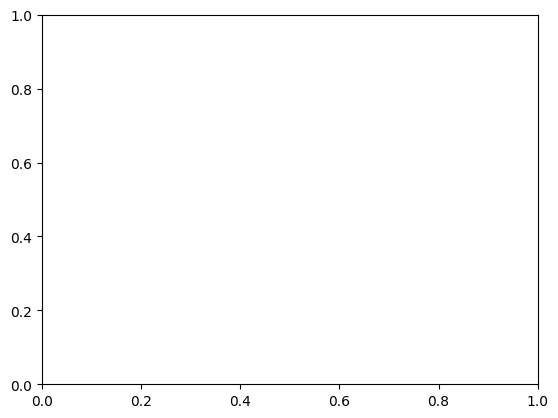

In [21]:
for idx in range(10):
    mushroom.train_dl.dataset.display_batch(
        batch, idx, mushroom.learner_data.dtype_to_channels,
        display_channels={'xenium': 'EPCAM', 'multiplex': 'E-Cadherin', 'visium': 'EPCAM', 'he': 'green'}
    )
    plt.show()

In [22]:
device = mushroom.model.device
with torch.no_grad():
    tiles, slides, dtypes = batch['tiles'], batch['slides'], batch['dtypes']
    pairs, is_anchor = batch['pairs'], batch['is_anchor']
    
    tiles, slides, dtypes = [x.to(device) for x in tiles], [x.to(device) for x in slides], [x.to(device) for x in dtypes]
    pairs, is_anchor = [x.to(device) for x in pairs], [x.to(device) for x in is_anchor]
    losses, outputs = mushroom.model.sae(tiles, slides, dtypes, pairs=pairs, is_anchor=is_anchor)

In [23]:
losses

{'neigh_loss_level_0': tensor(1.9835),
 'recon_loss_0_visium': tensor(1.3400),
 'neigh_loss_level_1': tensor(1.2548),
 'recon_loss_1_visium': tensor(1.3399),
 'neigh_loss_level_2': tensor(0.5782),
 'recon_loss_2_visium': tensor(1.3399),
 'recon_loss': tensor(4.0198),
 'neigh_loss': tensor(3.8166),
 'overall_loss': tensor(4.0198)}

In [24]:
outputs.keys()

dict_keys(['encoded_tokens_prequant', 'level_to_encoded', 'cluster_probs', 'clusters', 'dtype_to_true_pixels', 'dtype_to_pred_pixels'])

In [25]:
for level in outputs['cluster_probs']: print(level.shape)

torch.Size([256, 64, 8])
torch.Size([256, 64, 4])
torch.Size([256, 64, 2])


In [26]:
for level in outputs['clusters']: print(level.shape)

torch.Size([256, 64])
torch.Size([256, 64])
torch.Size([256, 64])


In [27]:
for level in outputs['clusters']: print(level.unique())

tensor([0, 1, 2, 3, 4, 5, 6, 7])
tensor([0, 1, 2, 3])
tensor([0, 1])


In [28]:
for level in outputs['level_to_encoded']: print(len(level.sum(-1).unique()))

8
32
64


In [29]:
for k, v in outputs['dtype_to_true_pixels'].items():
    print(k, v.shape)

visium torch.Size([256, 64, 14558])


In [30]:
for k, v in outputs['dtype_to_pred_pixels'].items():
    print(k, v.shape)

visium torch.Size([3, 256, 64, 14558])


In [31]:
sum([v.shape[1] for k, v in outputs['dtype_to_true_pixels'].items()])

64

In [29]:
# ~11 iter per second

In [14]:
mushroom.train()

/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /data/estorrs/mushroom/data/projects/htan_talk/mushroom/integrated_HT225C1_v1/outputs/chkpts exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 33.7 M
------------------------------
33.7 M    Trainable params
0         Non-trainable params
33.7 M    Total params
134.842   Total estimated model params size (MB)
/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
# mushroom.embed_sections()

In [ ]:
# outputs = []
# pl_module = mushroom.model
# with torch.no_grad():
#     for batch in mushroom.inference_dl:
#         tiles, slides, dtypes = batch['tiles'], batch['slides'], batch['dtypes']
#         tiles = [x.to(pl_module.device) for x in tiles]
#         slides = [x.to(pl_module.device) for x in slides]
#         dtypes = [x.to(pl_module.device) for x in dtypes]
#         outs = pl_module.forward(tiles, slides, dtypes)
#         outputs.append(outs)

In [ ]:
# out = mushroom.model.format_prediction_outputs(outputs)

In [15]:
os.path.join(mushroom_config['trainer_kwargs']['save_dir'], 'mushroom_config.yaml')

'/data/estorrs/mushroom/data/projects/htan_talk/mushroom/integrated_HT225C1_v1/outputs/chkpts/mushroom_config.yaml'

In [15]:
#using v98
new = Mushroom.from_config(
    os.path.join(mushroom_config['trainer_kwargs']['save_dir'], 'mushroom_config.yaml'),
    chkpt_filepath='/data/estorrs/mushroom/data/projects/htan_talk/mushroom/integrated_HT225C1_v1/outputs/chkpts/last-v6.ckpt',
    accelerator='cpu'
)


INFO:root:starting visium processing
INFO:root:using 12676 channels
INFO:root:4 sections detected: ['s0', 's1', 's2', 's3']
INFO:root:processing sections
INFO:root:generating image data for section s0
INFO:root:generating image data for section s1
INFO:root:generating image data for section s2
INFO:root:generating image data for section s3
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 4 sections detected: [('s0', 'visium'), ('s1', 'visium'), ('s2', 'visium'), ('s3', 'visium')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/lightning/pytorch/loggers/wandb.py:389: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU avai

In [16]:
new.embed_sections()

/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

In [17]:
dtype_to_df = new.get_cluster_intensities()
dtype_to_df['visium']

A1BG      A1CF       A2M    A4GALT      AAAS      AACS     AADAT  \
0   0.257838  0.230610  0.491687  0.134710  0.266907  0.155588  0.083363   
1   0.157776  0.074457  0.340448  0.058867  0.104793  0.057733 -0.001968   
2  -0.623035 -0.773178 -0.942899 -0.341528 -0.771947 -0.711230 -0.418227   
3  -0.307917 -0.309274 -0.338085 -0.207297 -0.349203 -0.374927 -0.203763   
4  -0.447480 -0.510786 -0.590366 -0.251978 -0.531530 -0.512907 -0.285837   
5   0.640906  0.588704  1.055371  0.571549  0.780779  0.613837  0.302690   
6   0.736558  0.227095  1.239145  0.912198  0.822277  0.521670  0.169746   
7   0.429474  0.632746  0.725143  0.134737  0.530972  0.474160  0.293435   
8   0.387894  0.260273  0.702536  0.324743  0.437818  0.263060  0.124593   
9   0.129217  0.247583  0.382896 -0.027148  0.167886  0.094392  0.076932   
10  0.757932  0.965580  1.108929  0.450201  0.958320  0.965033  0.558264   
11  1.089287  0.920910  1.708251  1.323326  1.415673  1.291225  0.588028   
12  1.017942  1.304123  1.563855  0.890738  1.427396  1.533883  0.811950   
13  0.219326  0.242750  0.454986  0.106457  0.251028  0.125182  0.056618   
14 -0.105432 -0.075374  0.002765 -0.114855 -0.123580 -0.188489 -0.080727   
15  0.542685  0.708442  0.845012  0.312499  0.670916  0.614058  0.378720   

       AAGAB      AAK1     AAMDC  ...    ZSWIM8      ZUP1      ZW10    ZWILCH  \
0   0.100635  0.172688  0.283819  ...  0.283665  0.121666  0.163144  0.097414   
1  -0.052683  0.057615  0.122546  ...  0.184420  0.046700  0.020994 -0.037364   
2  -0.648034 -0.477774 -0.798946  ... -0.747578 -0.458393 -0.494230 -0.615323   
3  -0.362845 -0.235959 -0.388661  ... -0.362230 -0.201284 -0.243321 -0.312064   
4  -0.481440 -0.329678 -0.565812  ... -0.499752 -0.305615 -0.362913 -0.449138   
5   0.580641  0.628439  0.838396  ...  0.896708  0.400134  0.475199  0.425910   
6   0.441636  0.846895  0.878188  ...  1.116659  0.252918  0.379824  0.163816   
7   0.419031  0.286917  0.574455  ...  0.484381  0.365859  0.367925  0.446030   
8   0.226465  0.338061  0.470567  ...  0.516163  0.153951  0.231632  0.147678   
9   0.079170  0.057435  0.160719  ...  0.142763  0.116119  0.110749  0.129568   
10  0.835403  0.624962  1.059411  ...  0.975273  0.633367  0.663946  0.795621   
11  1.224273  1.452785  1.633123  ...  1.864079  0.859948  0.875543  0.785549   
12  1.346923  1.163892  1.594783  ...  1.605840  1.019934  0.996556  1.129864   
13  0.098183  0.138866  0.152787  ...  0.195873  0.056189  0.204831  0.139838   
14 -0.181228 -0.099530 -0.164523  ... -0.139334 -0.072467 -0.087870 -0.124510   
15  0.581302  0.441843  0.708451  ...  0.663117  0.442262  0.501953  0.545987   

       ZWINT      ZXDB      ZXDC    ZYG11B       ZYX     ZZEF1  
0   0.221093  0.071340  0.113383  0.171279  0.461135  0.195351  
1   0.047977  0.040659  0.017593  0.025586  0.317145  0.062940  
2  -0.779450 -0.346790 -0.537286 -0.476116 -0.604942 -0.558496  
3  -0.366292 -0.181718 -0.292609 -0.260772 -0.328461 -0.271447  
4  -0.562068 -0.242958 -0.381250 -0.349961 -0.426835 -0.377635  
5   0.572279  0.300381  0.555639  0.626938  1.299860  0.698615  
6   0.244033  0.251379  0.535610  0.836391  2.335622  0.890682  
7   0.662544  0.222765  0.347435  0.261613  0.256210  0.320954  
8   0.272892  0.117794  0.237057  0.345047  0.919405  0.384994  
9   0.239317  0.041040  0.033694  0.063539  0.042361  0.048108  
10  1.012861  0.464531  0.756481  0.566155  0.761339  0.723839  
11  0.820042  0.617342  1.267831  1.359422  2.822941  1.430881  
12  1.258989  0.750383  1.284031  0.994578  1.504717  1.228075  
13  0.269065  0.084904  0.061532  0.228246  0.375899  0.149242  
14 -0.102512 -0.089081 -0.162494 -0.096837 -0.127935 -0.128851  
15  0.718516  0.317951  0.511489  0.428209  0.569850  0.506799  

[16 rows x 12676 columns]

array([[<Axes: title={'center': 's0'}, ylabel='predicted'>,
        <Axes: title={'center': 's1'}>, <Axes: title={'center': 's2'}>,
        <Axes: title={'center': 's3'}>],
       [<Axes: ylabel='true'>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

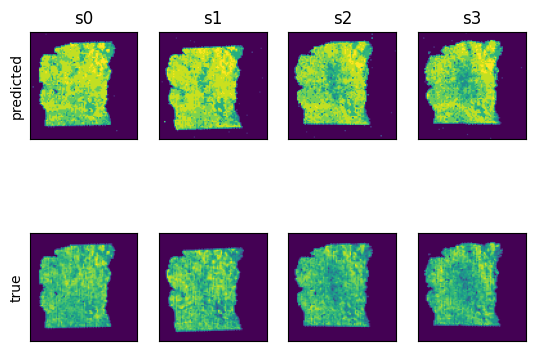

In [18]:
new.display_predicted_pixels('EPCAM', 'visium', level=-1)

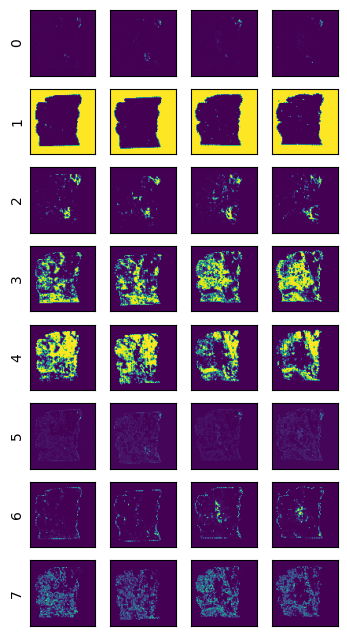

In [19]:
new.display_cluster_probs(level=0)

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 14 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 14 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 2

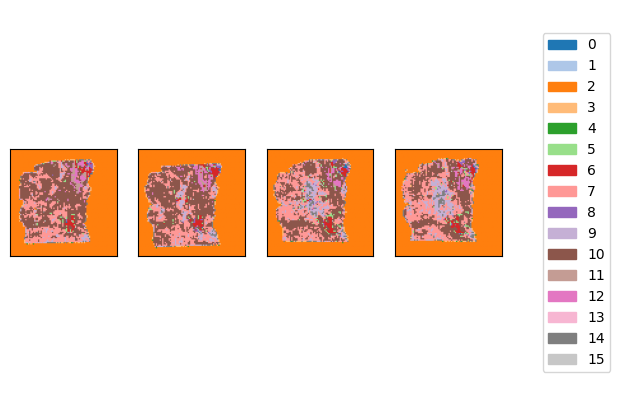

In [57]:
new.display_clusters()
plt.savefig('/data/estorrs/sandbox/HT225C1_l2_neighborhoods.pdf', dpi=300)

In [27]:
volume = new.generate_interpolated_volume(z_scaler=.05)
volume.shape

(7, 84, 84)

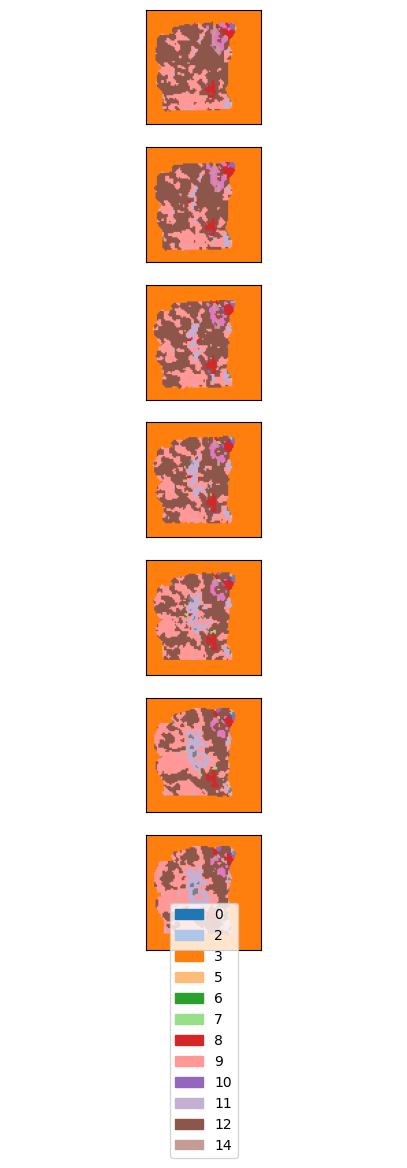

In [28]:
vis_utils.display_clusters(volume, horizontal=False, preserve_indices=True)

In [29]:
new.clusters[-1].shape

(4, 84, 84)

In [30]:
new.cluster_probs[-1].shape

(4, 84, 84, 2)

In [31]:
out_fp = os.path.join(mushroom_config['trainer_kwargs']['save_dir'], 'outputs.npy')
np.save(out_fp, {
    'cluster_ids': new.clusters,
    'cluster_probs': new.cluster_probs,
    'cluster_volume': volume,
})


In [47]:
import mushroom.data.datasets as datasets
import mushroom.data.visium as visium

In [48]:
sid_to_filepaths, section_ids, fps = datasets.get_config_info(config, 'visium')
sid_to_adata = {sid:visium.adata_from_visium(fp) for sid, fp in sid_to_filepaths.items()}

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 14 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'M', 'P', 'four', 'nonmarkingreturn', 'one', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 36, 38, 40, 48, 51]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 14 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'M', 'P', 'four', 'nonmarkingreturn', 'one', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 36, 38, 40, 48, 51]
INFO:fontTool

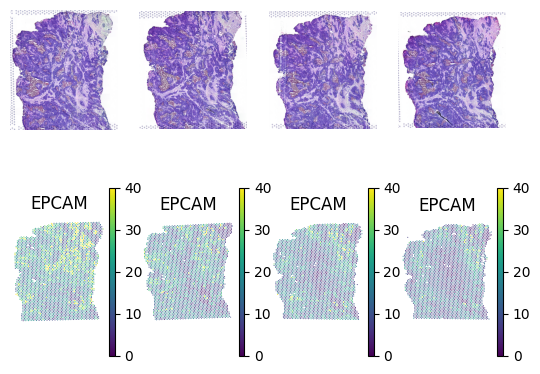

In [56]:
fig, axs = plt.subplots(ncols=len(sid_to_adata), nrows=2)
for i, (sid, adata) in enumerate(sid_to_adata.items()):
    ax = axs[0, i]
    sc.pl.spatial(adata, ax=ax, show=False)
    ax.axis('off')
    
    ax = axs[1, i]
    sc.pl.spatial(adata, color=['EPCAM'], ax=ax, show=False, size=1., alpha_img=0., vmax=40)
    ax.axis('off')
    
plt.savefig('/data/estorrs/sandbox/HT225C1_sections.pdf', dpi=300)
    

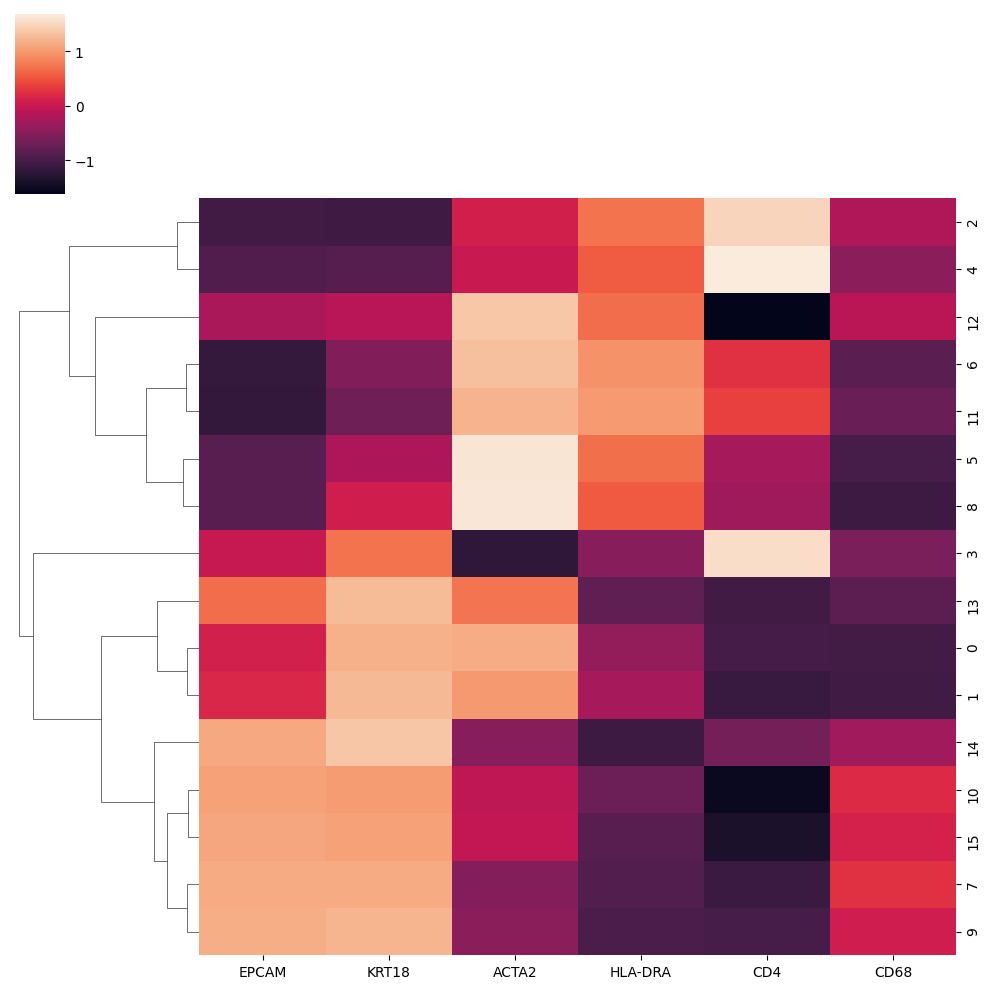

In [41]:
genes = ['EPCAM', 'KRT18', 'ACTA2', 'HLA-DRA', 'CD4', 'CD68']
sns.clustermap(dtype_to_df['visium'][genes], col_cluster=False, z_score=False)

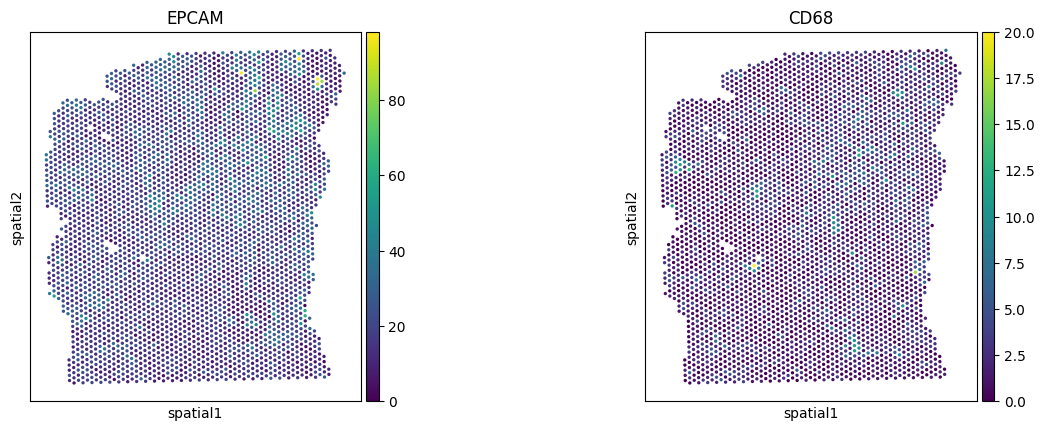

In [39]:
sc.pl.spatial(adata, color=['EPCAM', 'CD68'], alpha_img=0.)

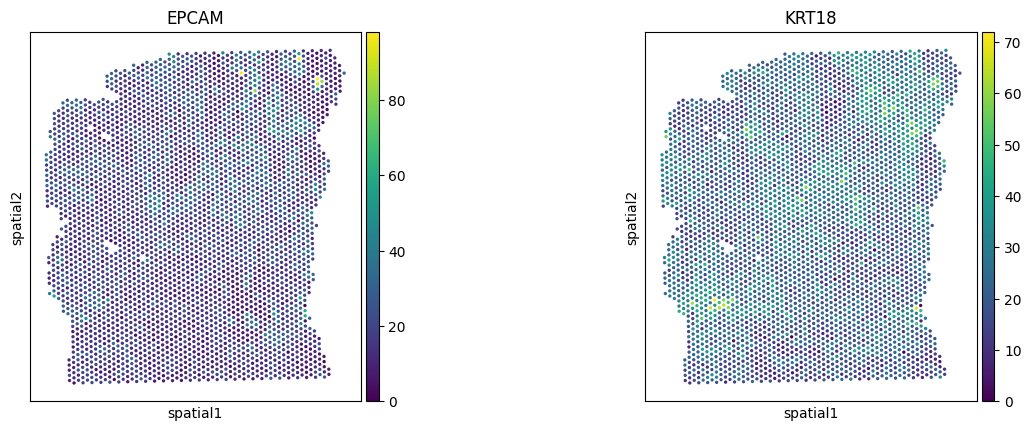

In [42]:
sc.pl.spatial(adata, color=['EPCAM', 'KRT18'], alpha_img=0.)

In [38]:
adata = sc.read_h5ad('/data/estorrs/mushroom/data/projects/htan_talk/registered/HT225C1/s0_visium.h5ad')
adata

AnnData object with n_obs × n_vars = 3681 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

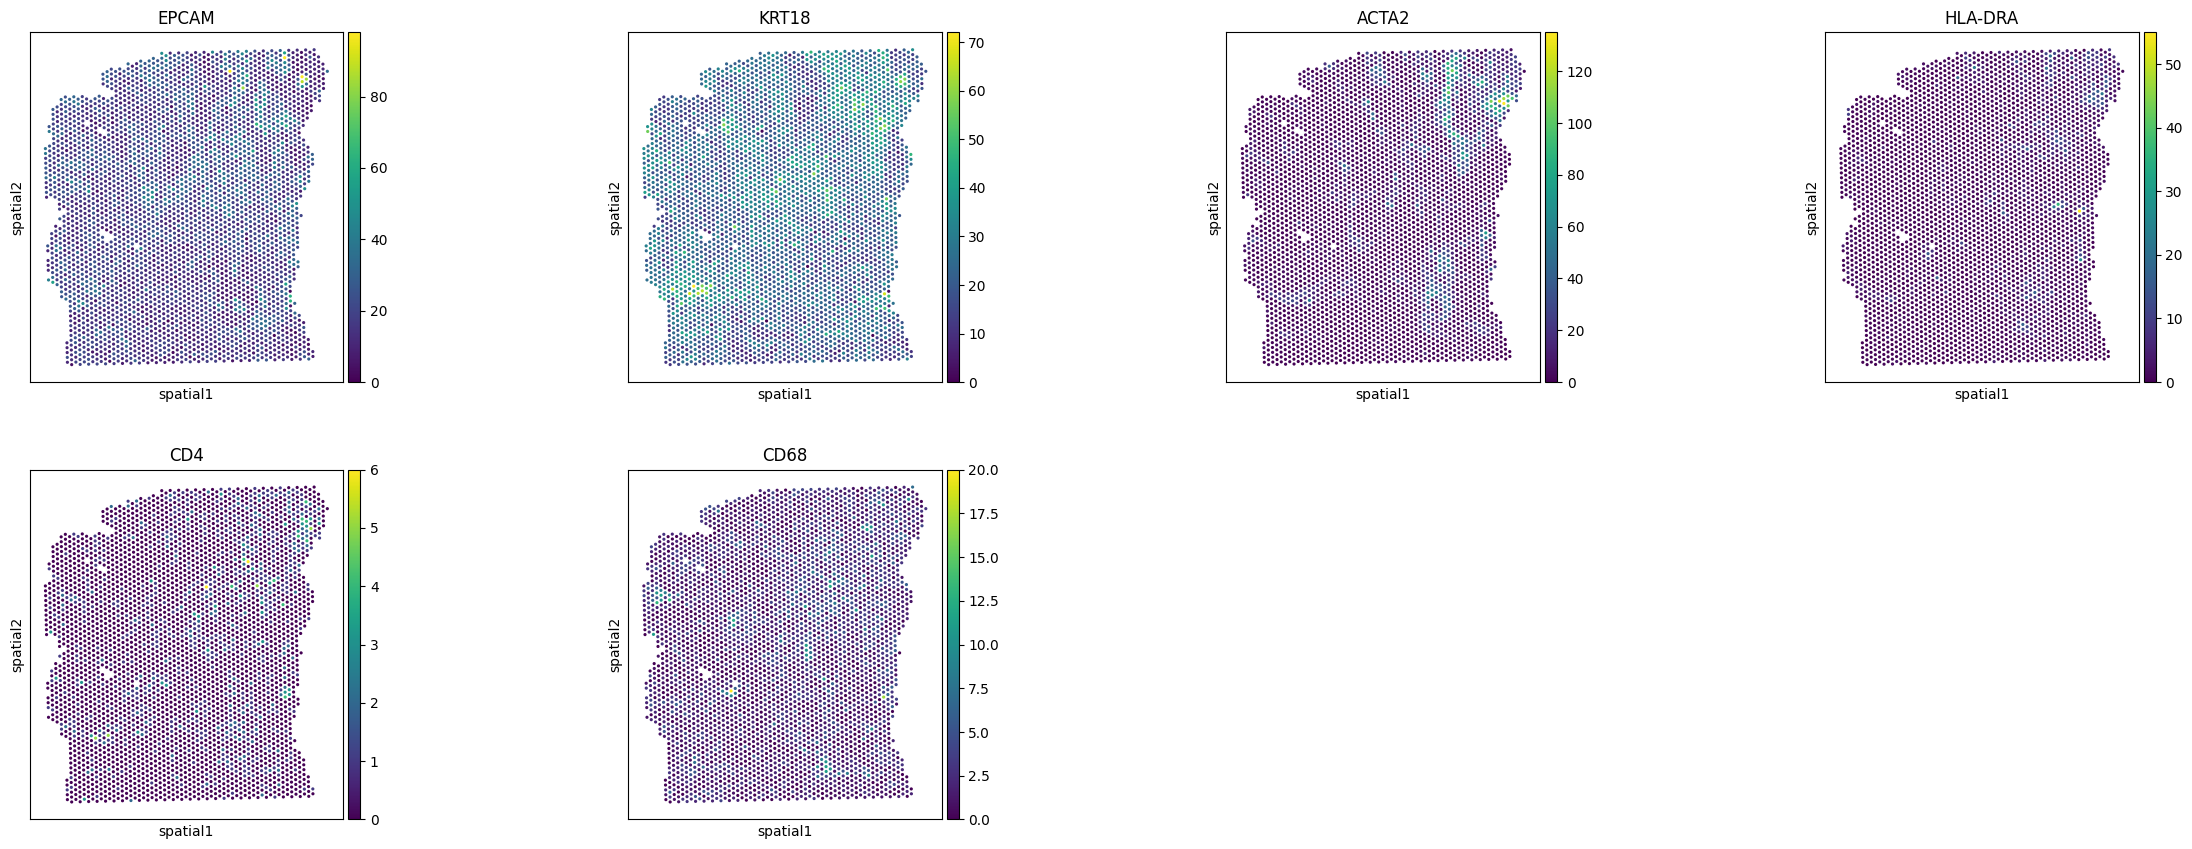

In [16]:
genes = ['EPCAM', 'KRT18', 'ACTA2', 'HLA-DRA', 'CD4', 'CD68']
sc.pl.spatial(adata, color=genes, alpha_img=0.)

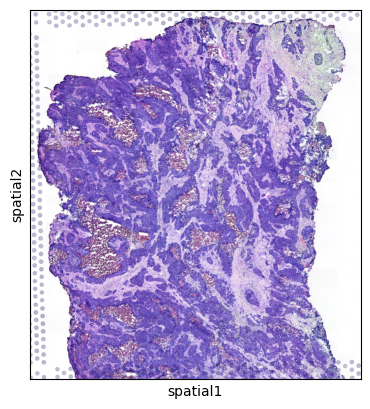

In [51]:
sc.pl.spatial(adata)

In [41]:
adata

AnnData object with n_obs × n_vars = 3681 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [57]:
def to_multiplex(adata, tiling_size=64):
    size = visium.get_fullres_size(adata)
    n_rows, n_cols = size[-2] // tiling_size + 1, size[-1] // tiling_size + 1

    pts = adata.obsm['spatial'][:, [1, 0]]

    img = np.zeros((n_rows, n_cols, adata.shape[1]))
    for r in range(n_rows):
        r1, r2 = r * tiling_size, (r + 1) * tiling_size
        row_mask = ((pts[:, 0] >= r1) & (pts[:, 0] < r2))
        row_adata, row_pts = adata[row_mask], pts[row_mask]
        for c in range(n_cols):
            c1, c2 = c * tiling_size, (c + 1) * tiling_size
            col_mask = ((row_pts[:, 1] >= c1) & (row_pts[:, 1] < c2))
            
            filtered = row_adata[col_mask]
            
            # adjust by distance to center
            
            
            img[r, c] = filtered.X.sum(0)
    return img

In [91]:
grid_pts = np.stack(np.meshgrid(np.arange(10), np.arange(10)))
grid_pts.shape

(2, 10, 10)

In [88]:
x = rearrange(grid_pts, 'b h w -> (h w) b')
x.shape

(100, 2)

In [89]:
rearrange(x, '(h w) b -> b h w', h=10)

array([[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]],

       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
        [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
        [5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
        [6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
        [7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
        [8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]]])

In [106]:
def to_multiplex(adata, tiling_size=64, radius_sf=1.):
    size = visium.get_fullres_size(adata)
    n_rows, n_cols = size[-2] // tiling_size + 1, size[-1] // tiling_size + 1

    pts = adata.obsm['spatial'][:, [1, 0]]
    grid_pts = np.meshgrid(np.arange(n_rows), np.arange(n_cols)) # (2, n_rows, n_cols)
    grid_pts = rearrange(grid_pts, 'b h w -> (h w) b')
    
    nbhs = NearestNeighbors(radius=tiling_size * radius_sf)
    nbhs.fit(pts)
    transformed = grid_pts * tiling_size + tiling_size / 2
    dists, idxs = nbhs.radius_neighbors(transformed)
    dists = 1 - (dists / tiling_size)

    img = np.zeros((n_rows, n_cols, adata.shape[1]))
    
    for (r, c), distances, indices in zip(grid_pts, dists, idxs):
        vals = adata.X[indices] * rearrange(distances, 'd -> d 1')
        img[r, c] = vals.sum(0)

    return img

In [17]:
def to_multiplex(adata, tiling_size=64, method='radius', radius_sf=1.):
    size = visium.get_fullres_size(adata)
    n_rows, n_cols = size[-2] // tiling_size + 1, size[-1] // tiling_size + 1

    pts = adata.obsm['spatial'][:, [1, 0]]

    print(tiling_size, method, n_rows, n_cols, pts.shape)

    if method == 'radius':
        grid_pts = np.meshgrid(np.arange(n_rows), np.arange(n_cols)) # (2, n_rows, n_cols)
        grid_pts = rearrange(grid_pts, 'b h w -> (h w) b')
        
        nbhs = NearestNeighbors(radius=tiling_size * radius_sf)
        nbhs.fit(pts)
        print('here')
        transformed = grid_pts * tiling_size + tiling_size / 2
        dists, idxs = nbhs.radius_neighbors(transformed)
        dists = 1 - (dists / tiling_size)

        img = np.zeros((n_rows, n_cols, adata.shape[1]))
        
        for (r, c), distances, indices in zip(grid_pts, dists, idxs):
            vals = adata.X[indices] * rearrange(distances, 'd -> d 1')
            img[r, c] = vals.sum(0)
    elif method == 'grid':
        img = np.zeros((n_rows, n_cols, adata.shape[1]))
        for r in range(n_rows):
            r1, r2 = r * tiling_size, (r + 1) * tiling_size
            row_mask = ((pts[:, 0] >= r1) & (pts[:, 0] < r2))
            row_adata, row_pts = adata[row_mask], pts[row_mask]
            for c in range(n_cols):
                c1, c2 = c * tiling_size, (c + 1) * tiling_size
                col_mask = ((row_pts[:, 1] >= c1) & (row_pts[:, 1] < c2))
                img[r, c] = row_adata[col_mask].X.sum(0)
    else:
        raise RuntimeError(f'method was {method}, can only be "grid" or "radius"')

    return img

In [22]:
img = to_multiplex(adata, tiling_size=250)

250 radius 80 79 (3681, 2)
here


In [104]:
img.max()

549.0876108497031

In [21]:
from sklearn.neighbors import NearestNeighbors

In [62]:
tiling_size=248
nbhrs = NearestNeighbors(radius=tiling_size)
nbhrs.fit(adata.obsm['spatial'])

NearestNeighbors(radius=248)

In [68]:
x = nbhrs.radius_neighbors_graph(X=np.asarray([[5000, 10000], [1000, 2000]])).toarray()
x

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [69]:
x[x>0]

array([1., 1., 1.])

In [75]:
dists, idxs = nbhrs.radius_neighbors(X=np.asarray([[5000, 10000], [10000, 5000]]))
dists = 1 - (dists / tiling_size)
dists, idxs

(array([array([0.53210167, 0.30798886, 0.39660118]),
        array([0.09723334, 0.10272518, 0.7257768 , 0.27391358])],
       dtype=object),
 array([array([1610,  492,  391]), array([2976,  563, 1408, 1349])],
       dtype=object))

In [82]:
adata.X[idxs[0]] * np.expand_dims(dists[0], -1)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [58]:
img = to_multiplex(adata, tiling_size=248)
img.shape

(81, 80, 36601)

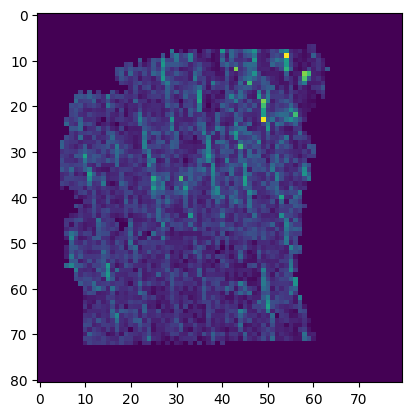

In [60]:
plt.imshow(img[..., adata.var.index.to_list().index('EPCAM')])

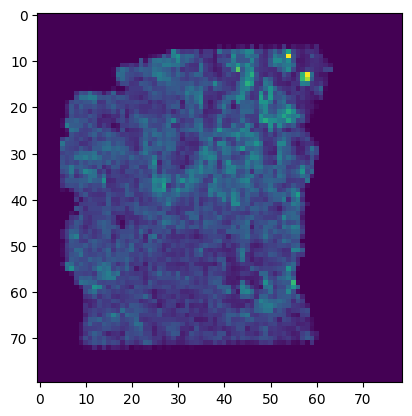

In [23]:
plt.imshow(img[..., adata.var.index.to_list().index('EPCAM')])

In [29]:
adata.X.min(0).shape

(36601,)